# Slippage Paper 2

In [2]:
from IPython.display import Latex

# Summary

$$
\text{Introduction : }

\text{This work investigates the decomposition of transaction costs into permanent and transitory price effects, specifically addressing concerns about the impact of high-frequency trading and market automation on institutional investors. It extends the classic "implementation shortfall" framework by including a detailed analysis of the transitory price component, which is particularly relevant for large orders executed in multiple smaller trades.}
$$

$$
\text{Implementation Shortfall : }
\text{The implementation shortfall measures the difference between the paper portfolio and the actual executed portfolio:}
$$
$$
\begin{equation}
\text{Impl. Shortfall} = \sum \sum (p_{ij} - p_{bi}) t_{ij} + \sum \sum (p_{ei} - p_{bi})(n_i - \omega_{ei})
\end{equation}
$$
$$

\text{where } p_{ij} \text{ and } p_{bi} \text{ are transaction prices and benchmark prices respectively, and } t_{ij} \text{ represents the number of shares traded.}

$$

$$
\text{Efficient Price and Pricing Errors : }
\text{The methodology assumes that the efficient price, } m_j \text{ , follows a martingale process:}
$$

$$
\begin{equation}
m_j = m_{j-1} + w_t
\end{equation}
$$

$$
\text{ The efficient price is estimated using a state-space model, which accounts for observed prices and decomposes them into efficient price and pricing error components: }
$$

$$

\begin{equation}
p_{ij} = \hat{m}_{ij} + s_{ij}
\end{equation}

$$

$$
\text{where } \hat{m}_{ij} \text{ is the smoothed efficient price and } s_{ij} \text{ is the pricing error.}
$$

$$
\text{ Decomposition of Implementation Shortfall : }
\text{ The execution cost component of the implementation shortfall can be decomposed as: }
$$
$$
\begin{equation}
\text{Execution Cost} = \sum \sum (p_{ij} - \hat{m}_{ij}) t_{ij} + \sum \sum (\hat{m}_{ij} - \hat{m}_{bi}) t_{ij} + \sum \sum (\hat{m}_{bi} - p_{bi}) t_{ij}
\end{equation}
$$

This includes liquidity costs, informational costs, and timing costs.

$$

$$
\text{The state space model is defined as: }
$$

$$
\text{Observation equation: }
$$
$$
p_t = [1 \quad 1 \quad 0] \begin{bmatrix} m_t \ s_t \ s_{t-1} \end{bmatrix}
$$
$$
\text{State equation: }
$$
$$
\begin{bmatrix} m_t \ s_t \ s_{t-1} \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 \ 0 & \phi_1 & \phi_2 \ 0 & 1 & 0 \end{bmatrix} \begin{bmatrix}
m_{t-1} \ s_{t-1} \ s_{t-2} \end{bmatrix} + \begin{bmatrix} 1 & 0 \ 0 & 1 \ 0 & 0 \end{bmatrix} \begin{bmatrix} w_t \ \varepsilon_t \end{bmatrix}
$$
$$
\text{Variance-covariance matrix of state innovations: }
$$
$$
\Omega = \begin{bmatrix} \sigma^2_w & \rho\sigma_w\sigma_\varepsilon & 0 \ \rho\sigma_w\sigma_\varepsilon & \sigma^2_\varepsilon & 0 \ 0 & 0 & 0 \end{bmatrix}
$$
$$
\text{Where: }
$$
$$
p_t \text{ is the observed price}
$$
$$
m_t \text{ is the efficient price component}
$$
$$
s_t \text{ is the pricing error component}
$$
$$
w_t \text{ and } \varepsilon_t \text{ are innovations to the efficient price and pricing error, respectively}
$$
$$
\phi_1 \text{ and } \phi_2 \text{ are AR coefficients for the pricing error}
$$
$$
\sigma_w \text{ and } \sigma_\varepsilon \text{ are standard deviations of the innovations}
$$
$$
\rho \text{ is the correlation between innovations}
$$

# Implementation

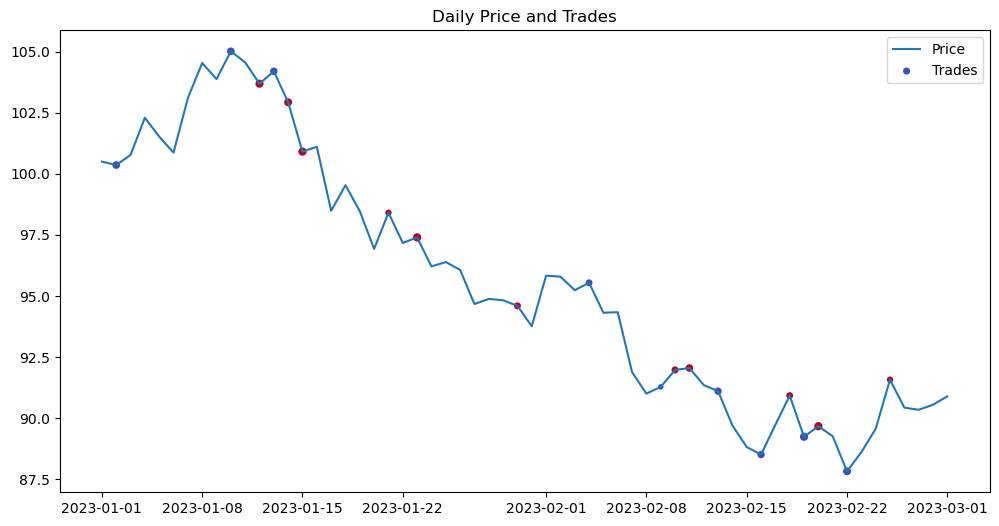

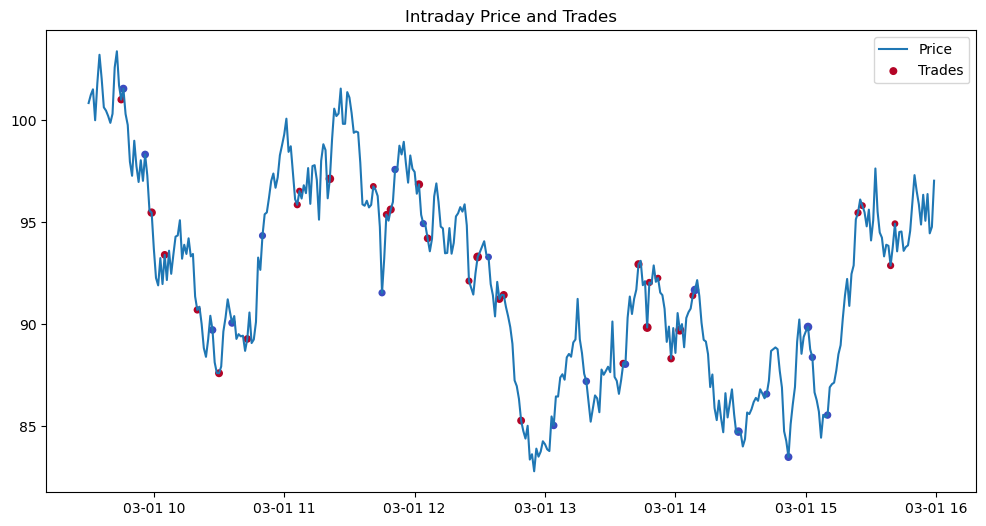

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

np.random.seed(42)  # For reproducibility

def generate_price_process(n_days, n_intraday=390, sigma_w=0.01, sigma_e=0.005, phi1=0.7, phi2=0.2):
    """
    Generate a price process with permanent and temporary components.
    
    n_days: number of days
    n_intraday: number of intraday observations per day (e.g., 390 minutes in a 6.5 hour trading day)
    """
    n_total = n_days * n_intraday
    
    # Generate permanent component (random walk)
    permanent = np.cumsum(np.random.normal(0, sigma_w, n_total))
    
    # Generate temporary component (AR(2) process)
    temporary = np.zeros(n_total)
    for t in range(2, n_total):
        temporary[t] = phi1 * temporary[t-1] + phi2 * temporary[t-2] + np.random.normal(0, sigma_e)
    
    # Combine permanent and temporary components
    price = 100 * np.exp(permanent + temporary)  # Start at price 100
    
    return price, permanent, temporary

def generate_trades(price, n_trades, avg_trade_size=1000):
    """Generate random trades."""
    trade_times = np.sort(np.random.choice(len(price), n_trades, replace=False))
    trade_sizes = np.random.normal(avg_trade_size, avg_trade_size/5, n_trades).astype(int)
    trade_signs = np.random.choice([-1, 1], n_trades)
    trade_sizes *= trade_signs
    
    trades = pd.DataFrame({
        'time': trade_times,
        'price': price[trade_times],
        'size': trade_sizes
    })
    
    return trades

# Generate daily data
n_days = 60
daily_price, daily_permanent, daily_temporary = generate_price_process(n_days, n_intraday=1)

daily_dates = [datetime(2023, 1, 1) + timedelta(days=i) for i in range(n_days)]
daily_data = pd.DataFrame({
    'date': daily_dates,
    'price': daily_price,
    'permanent': daily_permanent,
    'temporary': daily_temporary
})

daily_trades = generate_trades(daily_price, n_trades=20)
daily_trades['date'] = daily_trades['time'].apply(lambda x: daily_dates[x])

# Generate intraday data
n_intraday = 390  # 6.5 hours * 60 minutes
intraday_price, intraday_permanent, intraday_temporary = generate_price_process(1, n_intraday)

intraday_times = [datetime(2023, 3, 1, 9, 30) + timedelta(minutes=i) for i in range(n_intraday)]
intraday_data = pd.DataFrame({
    'time': intraday_times,
    'price': intraday_price,
    'permanent': intraday_permanent,
    'temporary': intraday_temporary
})

intraday_trades = generate_trades(intraday_price, n_trades=50, avg_trade_size=100)
intraday_trades['time'] = intraday_trades['time'].apply(lambda x: intraday_times[x])

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['price'], label='Price')
plt.scatter(daily_trades['date'], daily_trades['price'], 
            s=np.abs(daily_trades['size'])/50, c=daily_trades['size'] > 0, cmap='coolwarm', label='Trades')
plt.title('Daily Price and Trades')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(intraday_data['time'], intraday_data['price'], label='Price')
plt.scatter(intraday_trades['time'], intraday_trades['price'], 
            s=np.abs(intraday_trades['size'])/5, c=intraday_trades['size'] > 0, cmap='coolwarm', label='Trades')
plt.title('Intraday Price and Trades')
plt.legend()
plt.show()

# Save the data
daily_data.to_csv('daily_price_data.csv', index=False)
daily_trades.to_csv('daily_trades.csv', index=False)
intraday_data.to_csv('intraday_price_data.csv', index=False)
intraday_trades.to_csv('intraday_trades.csv', index=False)

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def create_state_space_model(price_data):
    # Prepare the data
    endog = price_data.values
    
    # Define the state space model
    model = SARIMAX(
        endog,
        order=(2, 1, 0),  # AR(2) for temporary component, integrated of order 1 for permanent component
        measurement_error=True,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    return model

In [11]:
# For daily data
daily_price_data = pd.read_csv('daily_price_data.csv')
model_daily = create_state_space_model(daily_price_data['price'])
results_daily = model_daily.fit(disp=False)

# For intraday data
intraday_price_data = pd.read_csv('intraday_price_data.csv')
model_intraday = create_state_space_model(intraday_price_data['price'])
results_intraday = model_intraday.fit(disp=False)

In [16]:
results_intraday.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -572.819
Date:                Mon, 24 Jun 2024   AIC                           1153.638
Time:                        20:11:02   BIC                           1169.471
Sample:                             0   HQIC                          1159.916
                                - 390                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.L1                    -0.0652      0.536     -0.122      0.903      -1.117       0.986
ar.L2                     0.0489      0.146      0.335      0.738      -0.237       0.335
var.measurement_error  3.154e-08      0.727   4.34e-08      1.000      -1.424       1.424
sigma2                    1.1302      1.363      0.829      0.407      -1.540       3.801
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.97   Prob(JB):                         0.65
Heteroskedasticity (H):               0.82   Skew:                             0.10
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
print(results_intraday.params)
sigma_w = np.sqrt(results_intraday.params[3])  # variance of the random walk component
sigma_epsilon = np.sqrt(results_intraday.params[2])  # variance of the measurement error

# The correlation between w and epsilon (rho) is not directly available in the SARIMAX results
# It's typically assumed to be zero in this model specification

phi_1 = results_intraday.params[0]
phi_2 = results_intraday.params[1]

print(f"sigma_w: {sigma_w}")
print(f"sigma_epsilon: {sigma_epsilon}")
print(f"phi_1: {phi_1}")
print(f"phi_2: {phi_2}")

[-6.52109020e-02  4.88738227e-02  3.15437178e-08  1.13022268e+00]
sigma_w: 1.0631193150450569
sigma_epsilon: 0.0001776055117668954
phi_1: -0.06521090199242638
phi_2: 0.04887382269624009


In [22]:
smoothed = results_intraday.smoothed_state
efficient_price_intraday = smoothed[0]

In [24]:
efficient_price_intraday

array([ 94.64643482, 100.85374437, 101.25223616, 101.52758112,
       100.01011499, 101.81307022, 103.22248622, 102.04993794,
       100.64352657, 100.48128663, 100.21457132,  99.88159083,
       100.32653265, 102.60270794, 103.39376824, 101.71397327,
       101.02137731, 101.55936097, 100.31822306,  99.77638424,
        97.97001467,  97.28542015,  99.00483186,  97.75964878,
        96.98113356,  98.04934668,  97.0359769 ,  98.32933934,
        97.29960046,  95.57813201,  95.48009656,  93.7174378 ,
        92.27467988,  91.90800093,  93.24736283,  91.97385107,
        93.40729736,  92.17007663,  93.61011557,  92.47564709,
        93.42069953,  94.30053892,  94.35779962,  95.10453134,
        93.21708429,  93.90110667,  93.45025654,  94.21726649,
        93.332954  ,  93.4502342 ,  91.36475112,  90.70445882,
        90.86041055,  90.01605177,  88.83739273,  88.40159332,
        89.25816744,  90.41732873,  89.72105254,  88.13209013,
        87.60541459,  87.59733662,  87.92921097,  89.64

In [26]:
def calculate_shortfall_components(trades, efficient_price, observed_price):
    # Ensure 'time' column in trades is datetime
    trades['time'] = pd.to_datetime(trades['time'])
    
    # Merge efficient and observed prices with trades
    trades = trades.merge(
        pd.DataFrame({'efficient_price': efficient_price, 'observed_price': observed_price}),
        left_on='time',
        right_index=True,
        how='left'
    )
    
    trades['sign'] = np.sign(trades['size'])
    
    # Calculate components
    trades['liquidity_cost'] = (trades['price'] - trades['efficient_price']) * trades['sign']
    trades['information_cost'] = (trades['efficient_price'] - efficient_price.iloc[0]) * trades['sign']
    trades['timing_cost'] = (efficient_price.iloc[0] - observed_price.iloc[0]) * trades['sign']
    
    # Calculate total cost
    trades['total_cost'] = trades['liquidity_cost'] + trades['information_cost'] + trades['timing_cost']
    
    # Calculate average costs
    avg_costs = trades[['liquidity_cost', 'information_cost', 'timing_cost', 'total_cost']].mean()
    
    return trades, avg_costs

# For intraday data
intraday_trades = pd.read_csv('intraday_trades.csv')
intraday_price_data = pd.read_csv('intraday_price_data.csv')

# Create a Series for efficient_price_intraday with the correct index
efficient_price_intraday_series = pd.Series(
    efficient_price_intraday, 
    index=pd.to_datetime(intraday_price_data['time'])
)

intraday_trades_with_costs, intraday_avg_costs = calculate_shortfall_components(
    intraday_trades, 
    efficient_price_intraday_series, 
    pd.Series(intraday_price_data['price'].values, index=pd.to_datetime(intraday_price_data['time']))
)

In [32]:
import matplotlib.pyplot as plt

def plot_price_decomposition(observed_price, efficient_price, trades):
    plt.figure(figsize=(12, 6))
    plt.plot(observed_price.index, observed_price, label='Observed Price')
    plt.plot(efficient_price.index, efficient_price, label='Efficient Price Estimate')
    
    buy_trades = trades[trades['size'] > 0]
    sell_trades = trades[trades['size'] < 0]
    
    plt.scatter(buy_trades['time'], buy_trades['price'], 
                s=buy_trades['size']/100, color='green', label='Buy')
    plt.scatter(sell_trades['time'], sell_trades['price'], 
                s=-sell_trades['size']/100, color='red', label='Sell')
    
    plt.legend()
    plt.title('Price Decomposition and Trades')
    plt.show()

# Plot intraday price decomposition
#plot_price_decomposition(
#    intraday_price_data['price'], 
#    pd.Series(efficient_price_intraday, index=intraday_price_data['time']),
#    intraday_trades
#"")

print("\nIntraday Average Costs:")
print(intraday_avg_costs)


Intraday Average Costs:
liquidity_cost      0.064512
information_cost    0.440971
timing_cost        -1.489754
total_cost         -0.984271
dtype: float64
